In [1]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models import get_qwz_graph, get_qwz_Ham, cdag_, c_
from networks import *
from helper import get_ed_data

In [2]:
L = 2  # Side of the square
N = L ** 2

graph, hi = get_qwz_graph(L)

In [3]:
m = 4.1
t = 1.0
U = 0.2
s = 0
p = 1

H = get_qwz_Ham(hi, graph, m = m, t = t, U = U)

# Exact diagonalization

evals, evecs = get_ed_data(H)
E_gs = evals[0]

Exact ground state energy: -17.375636311550128


In [4]:
def corr_func(i):
    return cdag_(hi, i, s) * c_(hi, 0, s) + cdag_(hi, i, p) * c_(hi, 0, p)

In [5]:
corrs = {}
for i in range(N):
    corrs[f"cdag{i}c0"] = corr_func(i)

# Slater Determinant

In [6]:
n_iter = 300
# Create the Slater determinant model
model = LogSlaterDeterminant(hi)

# Define the Metropolis-Hastings sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=f"data/slater_log_m={m}", obs = corrs)

  0%|          | 0/300 [00:00<?, ?it/s]

(JsonLog('data/slater_log_m=4.1', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.23499655723571777
   	Params: 0.1942121982574463,)

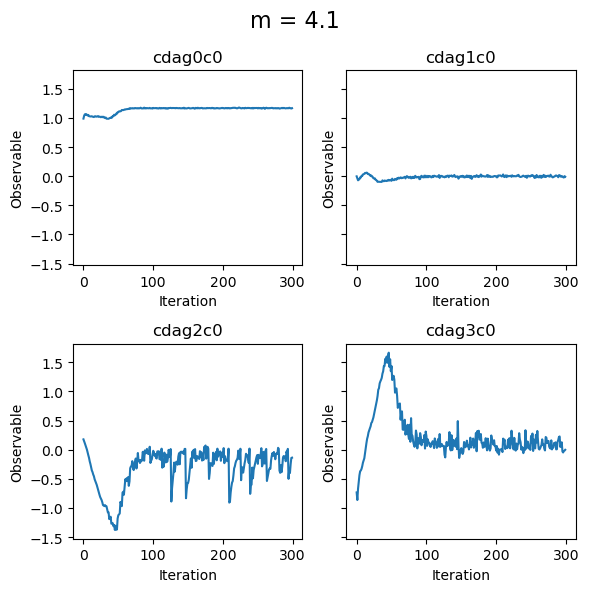

In [64]:
m = 4.1
data=json.load(open(f"slater_log_m={m}.log"))

x_values = np.arange(len(data['cdag0c0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'm = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


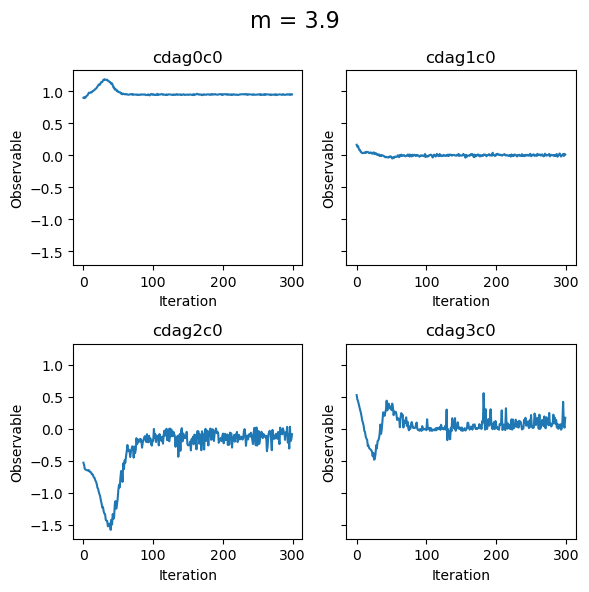

In [65]:
m = 3.9
data=json.load(open(f"slater_log_m={m}.log"))
x_values = np.arange(len(data['cdag0c0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'm = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [66]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -15.95+0.13j ± 0.33 [σ²=440.82, R̂=1.0022]
Relative error   : 0.04155833539251228


# Jastrow-Slater

In [86]:
# Create a Neural Jastrow Slater wave function 
model = LogNeuralJastrowSlater(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.01)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=f"data/nj_log_m={m}", obs = corrs)

  0%|          | 0/300 [00:00<?, ?it/s]

(JsonLog('nj_log_m=4.1', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.40413808822631836
   	Params: 0.44592714309692383,)

In [87]:
m = 4.1
data=json.load(open(f"nj_log_m={m}.log"))
data['cdag0c0']['Sigma']

[0.01979938276149432,
 0.019588288823579176,
 0.01990529649129881,
 0.02073059946838046,
 0.021626153675180074,
 0.02128571814332526,
 0.020965595606277098,
 0.02071861506327536,
 0.020357966774502252,
 0.018592441571905108,
 0.01808268870099787,
 0.01848931781092353,
 0.018378623930843385,
 0.01868839462377128,
 0.018749208731644457,
 0.018891292913601816,
 0.019257679952354886,
 0.01900399633917474,
 0.0184802236367393,
 0.01942037763197941,
 0.01818670673848461,
 0.018099725130130282,
 0.018239595915276068,
 0.01726171714694656,
 0.017817480280937038,
 0.017483959036021884,
 0.017737142870970918,
 0.01688501704786126,
 0.016389981645180126,
 0.015852640817513388,
 0.016423727983334333,
 0.015697397206348156,
 0.01611434687356396,
 0.016297286791001495,
 0.015654000548986687,
 0.015920932324227238,
 0.01637272688120552,
 0.016510658462952015,
 0.016752885725585753,
 0.01682706160802723,
 0.017082376210995044,
 0.0174921070280605,
 0.018114130032750017,
 0.01816588156830824,
 0.018811

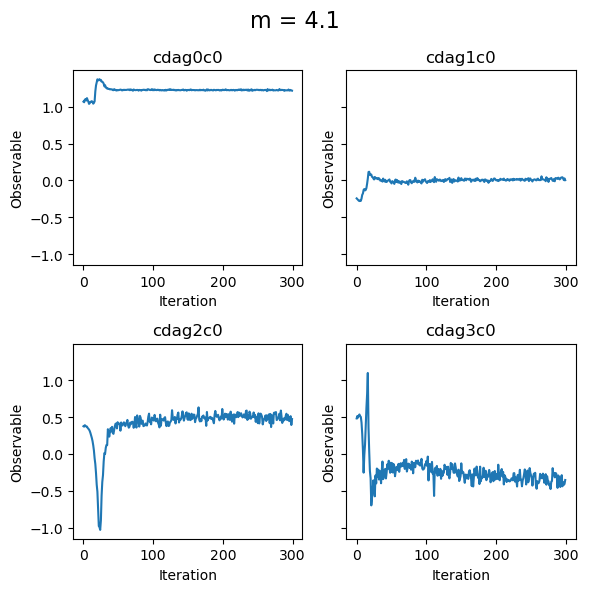

In [78]:
m = 4.1
data=json.load(open(f"nj_log_m={m}.log"))
x_values = np.arange(len(data['cdag0c0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'm = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


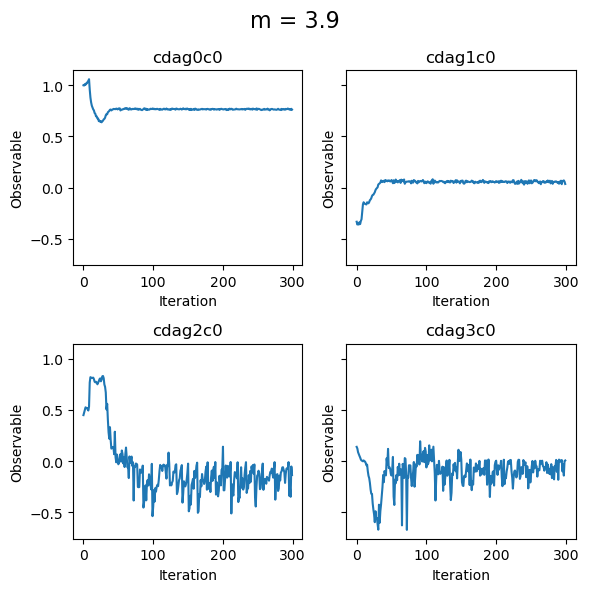

In [77]:
m = 3.9
data=json.load(open(f"nj_log_m={m}.log"))
x_values = np.arange(len(data['cdag0c0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'm = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [76]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -16.99-1.49j ± 0.53 [σ²=1119.93, R̂=1.0117]
Relative error   : 0.0888270864891798


# Neural-Backflow

In [45]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bf_log)

  0%|          | 0/300 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [46]:
sd_energy = vstate.expect(H)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -16.7+0.0j ± 1.2 [σ²=2346.7, R̂=1.0579]
Relative error   : 0.03744076060063865


In [47]:
data_slater = slater_log.data
print(data_slater)

{'acceptance': History(
   keys  = ['value'], 
   iters = [0, 1, ... 298, 299] (300 steps),
), 'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


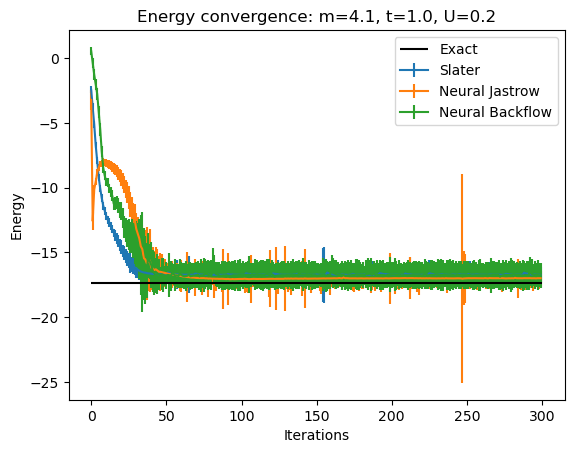

In [48]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.title(f"Energy convergence: m={m}, t={t}, U={U}")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

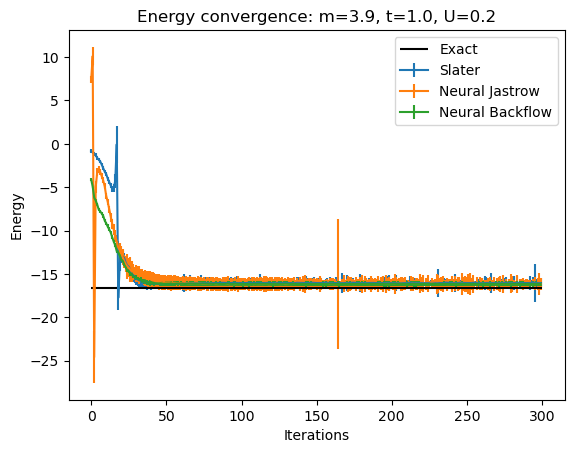

In [33]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")
plt.title(f"Energy convergence: m={m}, t={t}, U={U}")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()